In [1]:
import numpy as np
import json
import helpers as hp
import matplotlib.pyplot as plt

En esta RNA se utilizan ciertos indicadores como inputs. Estos indicadores estan definidos para cada tiempo t y debido a que algunos dependen de valores de tiempos anteriores hay que asignarles valores iniciales. El inconveniente con los valores iniciales es que los primeros valores de los indicadores pueden estar fuertemente influenciados por ellos, es por esta razón que es mejor no utilizar los primeros $M + \delta$ datos para el entrenamiento o validación, ya que pueden tener un cierto sesgo. Otra cosa extraña es que los indicadores usados en el paper parecen variar un poco respecto a sus definiciones formales. 

A continuación se exponen los indicadores utilizados y las diferencias entre los citados en el paper y las definiciones formales:

# EMA y EMSD

### Definición formal:

$$EMA_{M,t} = \alpha_M r_t + (1-\alpha_M)EMA_{M,t-1}$$
$$EMSD^2_{M,t} = (1-\alpha_M)(EMSD^2_{M,t-1} + \alpha_M(r_t-EMA_{M,t-1})^2)$$

### Definición en el paper:

$$EMA_{M,t} = \alpha_M r_{t-1} + (1-\alpha_M)EMA_{M,t-1}$$
$$EMSD^2_{M,t} = \alpha_M(r_{t-1}-EMA_{M,t-1})^2 + (1-\alpha_M)EMSD^2_{M,t-1}$$

En ambos casos se tiene:

$$ \alpha_M = \frac{2}{1+M} $$

El calculo de EMA se puede hacer a partir del  $t=M+1$ y el valor inicial que se le asigna para $t=M$ es el promedio de los valores para los primero $M$ periodos.

# RSI

### Definición en el paper:

En el paper el RSI se define de la siguiente manera:

$$RSI_{K,t} = \frac{PR_{K,t}}{PR_{K,t} + NR_{K,t}}$$

Donde cada elemento se define como:

$$PR_{K,t} = \sum_{k=1}^{K} max\{r_{t-k},0\}$$
$$NR_{K,t} = \sum_{k=1}^{K} max\{- r_{t-k},0\}$$

### Definición formal (https://en.wikipedia.org/wiki/Relative_strength_index):

Este indicador se tiene que descomponer en algunos pasos para entenderlo.

Primero se definen $U$ y $D$ para cada periodo cómo:

$$U_t = max\{ r_t - r_{t-1}, 0\}$$
$$D_t = max\{ -(r_t - r_{t-1}), 0\}$$

En palabras esto quiere decir que $U$ guarda la ganancia de los periodos, si esta es negativa (perdida) entonces toma el valor 0. Por otro lado $D$ guarda las perdidas de los periodos, si en un periodo hubo ganancias toma el valor 0. Hay que hacer enfasis en que los valores de $U$ y $D$ jamás son negativos. 

Teniendo esto se puede definir:

$$RS = \frac{SMMA(U,n)}{SMMA(D,n)}$$

$SMMA$ está definido como "smoothed moving average" y es equivalente a un $EMA$ con $M=\frac{1}{n}$

Finalmente se puede definir:

$$RSI = 100 - \frac{100}{1+RS}$$

Para poder relacionar las dos expresiones de una forma más clara tomemos en este caso a RSI como:

$$RSI_{K,t} = \frac{1}{1+RS_{K,t}}$$

Que sigue guardando la misma información solo se tiene que interpretar de forma ligeramente distinta. De esta forma la expresión se puede escribir de la siguiente forma:

$$RSI_{K,t} = \frac{SMMA(D,K)_{t}}{SMMA(U,K)_{t} + SMMA(D,K)_{t}}$$

Que ahora tiene la misma estructura que la definición del paper pero las expresiones que lo conforman no son las mismas. A continuación se tienen las de este último caso:

$$SMMA(D,K)_{t} = \frac{D_{t} + (K-1)SMMA(D,K)_{t-1}}{K}$$

$$SMMA(U,K)_{t} = \frac{U_{t} + (K-1)SMMA(U,K)_{t-1}}{K}$$

Algo que hay que considerar y que quizá pueda ser la razón por la que los autores del paper usan una definición diferente es que $r_t$ no guarda exactamente los close price del asset sino el cambio del precio del tiempo $t$ con respecto al tiempo $t-1$.

In [8]:
def get_return_data(price_data):
    """ Esta funcion regresa 'return data' (referencia en paper) en forma de un arreglo de numpy. El numero de 
        elementos de este arreglo es uno menos que price_data y su primero elementos corresponde al tiempo (indice)
        t=1 (suponiendo que el primer elemento de price_data corresponde a t=0).
        
        La funcion asume lo siguiente: 
            - price_data es un arreglo de numpy
            - price_data tiene al menos 2 elementos"""
    
    past_price_data = price_data[:-1]
    present_price_data = price_data[1:]
    return_data = (present_price_data/past_price_data) - 1
    
    return return_data


def get_formal_EMA_EMSD_data(x, M):
    """ La funcion regresa dos arreglos de numpy con los valores de EMA y EMSD de periodo-M a
        partir de x. Hay que tomar en cuenta que el primer elemento de cada uno de estos arreglos
        corresponde al tiempo (indice) t=M (suponiendo que el primer elemento de x corresponde a t=0)
        con respecto a x. El valor para t=M-1 corresponde al promedio de los primeros M elementos pero
        no se incluye y para tiempos anteriores el valor no esta definido.
        
        La funcion asume lo siguiente:
            - x es un arreglo de numpy
            - x tiene al menos M+1 elementos"""
    
    alpha         = 2/(1+M)
    past_EMA      = x[:M].mean()
    past_EMSD_sqr = 0
    n_elements    = x.shape[0]-M
    EMA_data      = np.zeros(n_elements)
    EMSD_data     = np.zeros(n_elements)
    
    for i in range(n_elements):
        EMA_data[i]   = alpha*x[i+M] + (1-alpha)*past_EMA
        EMSD_sqr      = (1-alpha)*(past_EMSD_sqr + alpha*((x[i+M]-past_EMA)**2))
        EMSD_data[i]  = EMSD_sqr**0.5
        past_EMA      = EMA_data[i]
        past_EMSD_sqr = EMSD_sqr
        
    return EMA_data, EMSD_data


def get_formal_SMMA(x, N):
    """ La funcion regresa un arreglo de numpy con el valor de SMMA de periodo-N de x. 
        Hay que tomar en cuenta que el primer elemento de este arreglo corresponde al tiempo 
        (indice) t=N (suponiendo que el primer elemento de x corresponde a t=0) con respecto 
        a x. El valor para t=N-1 corresponde al promedio de los primeros N elementos pero no se
        incluye y para tiempos anteriores el valor no esta definido.
        
        La funcion asume lo siguiente: 
            - x es un arreglo de numpy
            - x tiene al menos N+1 elementos"""
    
    alpha       = 1/N
    past_SMMA    = x[:N].mean()
    n_elements  = x.shape[0]-N
    SMMA_data   = np.zeros(n_elements)
    
    for i in range(n_elements):
        SMMA_data[i+N] = (x[i] + (N-1)*past_SMMA)/N
        past_SMMA    = SMMA_data[i]
        
    return SMMA_data
    

def get_formal_RSI(x, K):
    
    """ La funcion regresa un arreglo de numpy con los valores de RSI de N-periodo a partir de x. 
        Hay que tomar en cuenta que el primer elemento de este arreglo corresponde al tiempo 
        (indice) t=K+1 (suponiendo que el primer elemento de x corresponde a t=0) con respecto 
        a x. Los valores para t<K+1 estan indefinidos.
        
        La funcion asume que lo siguiente:
            - x es un arreglo de numpy
            - x tiene al menos K+2 elementos"""
    
    n_elements = x.shape[0]
    
    #Tomar en cuenta que aunque el primer elemento de U_data y D_data tiene el valor de 0
    #en realidad esta indefinido
    U_data     = np.zeros(n_elements)
    D_data     = np.zeros(n_elements)
    
    for i in range(1,n_elements):
        U_data[i] = max(x[i] - x[i-1], 0)
        D_data[i] = max(-(x[i] - x[i-1]), 0)
        
    SMMA_U = get_formal_SMMA(U_data[1:],K)
    SMMA_D = get_formal_SMMA(D_data[1:],K)
        
    RS_data = SMMA_U/SMMA_D
    RSI_data = 1/(1+RS_data)
    
    return RSI_data
    
    
def get_paper_EMA_EMSD_data(x, M):
    """ La funcion regresa dos arreglos de numpy con los valores de EMA y EMSD de periodo-M a
        partir de x. Hay que tomar en cuenta que el primer elemento de cada uno de estos arreglos
        corresponde al tiempo (indice) t=M (suponiendo que el primer elemento de x corresponde a t=0) 
        con respecto a x. El valor para t=M-1 corresponde al promedio de los primeros M elementos pero
        no se incluye y para tiempos anteriores el valor no esta definido.
        
        La funcion asume lo siguiente:
            - x es un arreglo de numpy
            - x tiene al menos M+1 elementos"""
    
    alpha         = 2/(1+M)
    past_EMA      = x[:M].mean()
    past_EMSD_sqr = 0
    n_elements    = x.shape[0]-M
    EMA_data      = np.zeros(n_elements)
    EMSD_data     = np.zeros(n_elements)
    
    for i in range(n_elements):
        EMA_data[i]   = alpha*x[i+M] + (1-alpha)*past_EMA
        EMSD_sqr      = (1-alpha)*past_EMSD_sqr + alpha*((x[i+M]-past_EMA)**2)
        EMSD_data[i]  = EMSD_sqr**0.5
        past_EMA      = EMA_data[i]
        past_EMSD_sqr = EMSD_sqr
        
    return EMA_data, EMSD_data


def get_paper_sumR(x, N):
    """ La funcion regresa un arreglo de numpy donde cada elemento representa la suma de N 
        elementos consecutivos de x. Hay que tomar en cuenta que el primer elemento de este 
        arreglo corresponde al tiempo (indice) t=N-1 (suponiendo que el primer elemento de x 
        corresponde a t=0) con respecto a x. Los valores para t<N-1 estan indefinidos.
        
        La funcion asume lo siguiente:
            - x es un arreglo de numpy
            - x tiene al menos N elementos"""
    
    n_elements = x.shape[0]-N+1
    sumR_data  = np.zeros(n_elements)
    
    for i in range(n_elements):
        sumR_data[i] = x[n_elements:n_elements+N].sum()

    return sumR_data


def get_paper_RSI(x, K):
    """ La funcion regresa un arreglo de numpy con los valores de RSI de N-periodo a partir de x. 
        Hay que tomar en cuenta que el primer elemento de este arreglo corresponde al tiempo 
        (indice) t=K-1 (suponiendo que el primer elemento de x corresponde a t=0) con respecto a
        x. Los valores para t<K-1 estan indefinidos.
        
        La funcion asume lo siguiente:
            - x es un arreglo de numpy
            - x tiene al menos K elementos"""
    
    n_elements = x.shape[0]
    
    posR_data  = np.zeros(n_elements)
    negR_data  = np.zeros(n_elements)
    
    for i in range(n_elements):
        posR_data[i] = max(x[i], 0)
        negR_data[i] = max(-x[i], 0)

    PR_data = get_paper_sumR(posR_data,K)
    NR_data = get_paper_sumR(negR_data,K)

    RSI_data = PR_data/(PR_data+NR_data)
    
    return RSI_data

Los datos que vamos a usar para probar este modelo se obtuvieron de coinAPI. El detalle con coinAPI es que tiene un limte en el número de datos al que se peude acceder para un lapso de 24H. Por esta razón los datos que se ocupan se obtuvieron durante varios días y se encuentran guardados en diferentes archivos. Lo que se hace en el siguiente bloque de código es obtener la información de todos estos periodos y juntarla en una sola variable. Esta se puede guardar si se desea en el directorio de donde se obtuvieron los datos para no tener que repetir este paso en otras ocasiones. Lo único que se recomienda es añadir en el nombre de este nuevo archivo la fecha de inicio y fin para tener como referencia.

In [3]:
source_dir_path = "../../dataAcquisition/coinAPI/data/coinbase/BTC-USD/"
files_names = ["COINBASE_SPOT_BTC_USD_1-1-2018_1-2-2018.json",
               "COINBASE_SPOT_BTC_USD_1-2-2018_6-3-2018.json",
               "COINBASE_SPOT_BTC_USD_6-3-2018_8-4-2018.json",
               "COINBASE_SPOT_BTC_USD_8-4-2018_12-5-2018.json",
               "COINBASE_SPOT_BTC_USD_12-5-2018_15-6-2018.json",
               "COINBASE_SPOT_BTC_USD_15-6-2018_19-7-2018.json",
               "COINBASE_SPOT_BTC_USD_19-7-2018_22-8-2018.json",
               "COINBASE_SPOT_BTC_USD_22-8-2018_25-9-2018.json",
               "COINBASE_SPOT_BTC_USD_25-9-2018_29-10-2018.json",
               "COINBASE_SPOT_BTC_USD_29-10-2018_2-11-2018.json",
               "COINBASE_SPOT_BTC_USD_2-11-2018_6-12-2018.json",
               "COINBASE_SPOT_BTC_USD_6-12-2018_9-1-2019.json",
               "COINBASE_SPOT_BTC_USD_9-1-2019_12-2-2019.json",
               "COINBASE_SPOT_BTC_USD_12-2-2019_18-3-2019.json",
               "COINBASE_SPOT_BTC_USD_18-3-2019_21-4-2019.json",
               "COINBASE_SPOT_BTC_USD_21-4-2019_25-5-2019.json",
               "COINBASE_SPOT_BTC_USD_25-5-2019_28-6-2019.json",
               "COINBASE_SPOT_BTC_USD_28-6-2019_1-7-2019.json",
               "COINBASE_SPOT_BTC_USD_1-7-2019_10-8-2019.json",
               "COINBASE_SPOT_BTC_USD_10-8-2019_13-9-2019.json",
               "COINBASE_SPOT_BTC_USD_13-9-2019_17-10-2019.json",
               "COINBASE_SPOT_BTC_USD_17-10-2019_20-11-2019.json",
               "COINBASE_SPOT_BTC_USD_20-11-2019_24-12-2019.json",
               "COINBASE_SPOT_BTC_USD_24-12-2019_27-1-2020.json",
               "COINBASE_SPOT_BTC_USD_27-1-2020_1-3-2020.json",
               "COINBASE_SPOT_BTC_USD_1-3-2020_4-4-2020.json",
               "COINBASE_SPOT_BTC_USD_4-4-2020_8-5-2020.json"]

ohlcv_data = []

for f in files_names:
    current_file_path = source_dir_path + f

    with open(current_file_path) as json_file:
        current_ohlcv_data = json.load(json_file)
    
    ohlcv_data += current_ohlcv_data
    
    
#Codigo para guardar datos en un solo archivo si se desea
# complete_ohlcv_data_path = source_dir_path + "allData/COINBASE_SPOT_BTC_USD_1-1-2018_4-4-2020.json"

# with open(complete_ohlcv_data_path, 'w') as json_file:
#         json.dump(ohlcv_data, json_file)

# p_data = np.zeros(len(data))

# for i in range(len(data)):
#     p_data[i] = data[i]["price_close"]

Ahora lo que queremos es armar los datos de entrenamiento que utilizan en el paper que son los siguientes:
    
 - $r_{t-1}$
 - $EMA_{M,t}$
 - $EMSD_{M,t}$
 - $RSI_{K,t}$
 
Para $M=2,4,12,24$ y $K=12,24,48$

Tomando esto en cuenta los vectores de entrada pertenecen a $\!R^{12}$

En los bloques que siguen lo que se hace es construir estos datos. Como se menciona anteriormente las definiciones de estos indicadores en el paper varían un poco con respecto a las definiciones formales. Lo que haremos es probar con las dos definiciones y ver cuales son los resutlados.

Otro punto que hay que tener presente es que los indicadores están indefinidos para un cierto número de datos al inicio. Específicamente para: 
 - $r_t$: Indefinido para el primer dato
 - $EMA_{M,t}$ y $EMSD_{M,t}$: Indefinido para los primeros $M$ datos
 - $RSI_{K,t}$: Indefinido para los primeros $K+1$ datos para la definición formal y para los primeros $K-1$ para la definición del paper

<br>
<br>

Hay que recordar además algo muy importante: Los datos pueden tener lagunas. Esto puede ser fatal para el calculo de los indicadores y hay que tratarlo con cuidado. Para esto se sigue el siguiente procedimiento:

 - Usar la funcion $hp.get\_valid\_data\_idx()$ para encontrar todos los periodos (identificados por indices) que se podrán usar. Siguiendo las definiciones del paper estos periodos son aquellos que tiene al menos 48 periodos consecutivos anteriores a ellos. Siguiendo las definiciones formales este número es 50. Lo que obtendremos de usar la función anteriormente mencionada son arreglos con los indices (que representan periodos) útiles entre lagunas consecutivas. Para cada arreglo estos indices deberían ser consecutivos, si esto no es así hay que revisar el código fuente porque algo está mal. Con estos indices se pueden armar los indicadores que se desean
 - Posteriormente tenemos que construir 'return data' ($r_t$), para cada intervalo útil entre lagunas.
 - Finalmente para cada intervalo válido de 'return data' se calculan los indicadores que ya se han descrito.

In [9]:
# Obtenemos los indices validos bajo la condición de que tengan al menos 51 elementos consecutivos anteriores en el 
# caso de los indicadores formales o 48 en el caso de los indicadores del paper. Esto esta dado por el indicador que
# mas periodos en el pasado necesita que en este caso es RSI con K=48. Si los indicadores se cambian este numero puede
# cambiar.
periods_before = 51
data_valid_idx = hp.get_valid_data_idx(ohlcv_data,"5MIN",periods_before)

In [10]:
# Obtenemos la información de precios valida en funcion de lo obtenido en el bloque anterior. 
# Hay que tener en cuenta que los indices validos (y necesarios) empiezan periods_before periodos 
# antes que el primer elemento de cada arreglo de indices validos.
# Esta informacion se guarda en un arreglo con subarreglos. Cada subarreglo tiene los precios
# validos para un intervalo definido entre dos lagunas.

valid_price_data = []

for valid_interval in data_valid_idx:
    valid_interval_len = len(valid_interval)
    n_useful_periods   = valid_interval_len + periods_before
    first_useful_idx   = valid_interval[0] - periods_before
    current_price_data = np.zeros(n_useful_periods)
    
    for i in range(n_useful_periods):
        current_price_data[i] = ohlcv_data[first_useful_idx+i]["price_close"]
    
    valid_price_data.append(current_price_data)

In [11]:
# Ahora calculamos 'return data' para cada subarreglo de valid_price_data. Lo que obtendremos sera un arreglo
# con el mismo numero de subarreglos que valid_price_data, pero ahora con 'return data'. Además hay que tomar 
# en cuenta que al hacer este calculo los arreglos que se obtengan tendran 1 elemento menos que el original
# y el primer elemento de estos corresponde a t=1

r_data = []

for vpd in valid_price_data:
    r_data.append(get_return_data(vpd))

In [12]:
# Ahora calculamos EMA y EMSD como se plantea en el paper. Lo que obtendremos sera un arreglo con el mismo 
# numero de subarreglos que r_data para cada indicador. Además hay que tomar en cuenta que al hacer este calculo 
# los subarreglos que se obtengan tendran M elementos menos que los originales y el primer elemento en ellos 
# correspondera a t= M+2 respecto a valid_price_data o t=M+1 respecto a r_data.

M_periods = [2,4,12,24]

EMA_data  = []
EMSD_data = []

for rd in r_data:
    valid_interval_EMA  = {}
    valid_interval_EMSD = {}
    
    for M in M_periods:
        current_EMA, current_EMSD = get_paper_EMA_EMSD_data(rd, M)
        current_period_key = f"M{M}"
        valid_interval_EMA[current_period_key]  = current_EMA
        valid_interval_EMSD[current_period_key] = current_EMSD
        
    EMA_data.append(valid_interval_EMA)
    EMSD_data.append(valid_interval_EMSD)
    

In [13]:
# Ahora calculamos RSI como se plantea en el paper. Lo que obtendremos sera un arreglo con el mismo 
# numero de subarreglos que r_data. Además hay que tomar en cuenta que al hacer este calculo los subarreglos
# que se obtengan tendran K-1 elementos menos que los originales y el primer elemento en ellos 
# correspondera a t= K+1 respecto a valid_price_data o t=K respecto a r_data.

K_periods = [12,24,48]

RSI_data  = []

for rd in r_data:
    valid_interval_RSI  = {}
    
    for K in K_periods:
        current_RSI = get_paper_RSI(rd, K)
        current_period_key = f"K{K}"
        valid_interval_RSI[current_period_key] = current_RSI
        
    RSI_data.append(valid_interval_RSI)


Hasta ahora tenemos ya todos los indicadores que necesitamos separados en varios arreglos. Hay que mencionar que los elementos entre arreglos no son consecutivos ya que los separan lagunas en los datos. Por lo tanto cada intervalo se tiene que tratar de forma totalmente independiente. El análisis que se hace a continuacion es para los indicadores obtenidos entre dos lagunas y es igual para cualquier intervalo. 

Para construir los datos de entrenamiento falta tomar en cuenta un pequeno detalle y es que el primer elemento de cada uno de los indicadores que se obtuvieron no correpsonden al mismo periodo. A continuación se decribira especificamente el caso de cada indicador.

A cada periodo se hará referencia con un tiempo discreto ($t=0,1,2,3...$). El tiempo ($t=0$) corresponde al primer periodo que se tiene en los datos historicos que corresponde al primer elemento de un arreglo entre dos lagunas o en términos de las variables que hemos construido al primer elemento de alguno de los arreglos que contiene la variable $valid\_price\_data$. Tomando este elemento como $t=0$ podemos definir el periodo al que corresponde el primer elemento de todos los otros indicadores (siguiendo las definiciones del paper, no las formales), lo cual se hace a continuación:

 - $r:$ $t=1$
 - $EMA_{M}:$ $t=M+1$
 - $EMSD_{M}:$ $t=M+1$
 - $RSI_{K}:$ $t=K$
 
Con los resultados anteriores lo que se tiene que hacer es fijarse en el indicador cuyo primer elemento corresponda al tiempo más al futuro y tomar todos los indicadores a partir de ese tiempo. De esta forma se peude asegurar que para todos los datos de entrenamiento que se usaran todos los indicadores estarán disponibles.

Algo extra que se puede hacer, recomendado en el paper, es no tomar exactamente los elementos a partir del tiempo anteriormente mencionado sino a partir de este más una cierta $\delta$. Esto se hace así debido a que los indicadores tiene un valor inicial que puede afectar los valores de los primeros elementos, sin embargo conforme el tiempo avanza esta influencia disminuye. 

A continuación se obtiene los datos de entrenamiento final. Lo que tiene que quedar claro es que estos pueden no ser continuos debido a que vienen de intervalos separados por lagunas. De esta forma puede ser que los elementos $i$ e $i+1$ no sean temporalmente consecutivos. A la hora del entrenamiento esto no tiene mucha importancia porque los datos entran de forma aleatoria. 

In [18]:
# Lo que hacemos a continuación es definir una delta y tomar todos los indicadores a partir del tiempo más al futuro
# entre todos los indicadores más una delta. Hay que tomar en cuenta que si la delta es muy grande quizá haya intervalos
# que no puedan contribuir con ningun dato. 

delta = 100

# Definimos el tiempo mas grande entre el conjunto de tiempos definido por aquellos en los que alguno de los 
# indicadores tiene su primer elemento
M_max = max(M_periods) + 1
K_max = max(K_periods)
t_max = max(M_max,K_max)

# Definimos el tiempo a partir del cual empezaran los datos de entrenamiento (t_start incluido en estos datos)
t_start = t_max + delta

final_r_data = []
final_EMA_data = {}
final_EMSD_data = {}
final_RSI_data  = {}

for M in M_periods:
    M_period_key = f"M{M}"
    final_EMA_data[M_period_key] = []
    final_EMSD_data[M_period_key] = []

for K in K_periods:
    K_period_key = f"K{K}"
    final_RSI_data[K_period_key] = []

    
    
n_intervals = len(r_data)

for i in range(n_intervals):
    n_elements = valid_price_data[i].shape[0]
    
    if n_elements >= t_start:
        final_r_data += r_data[i][t_start-1:].tolist()
        
        for M in M_periods:
            M_period_key = f"M{M}"
            final_EMA_data[M_period_key] += EMA_data[i][M_period_key][t_start-(M+1):].tolist()
            final_EMSD_data[M_period_key] += EMSD_data[i][M_period_key][t_start-(M+1):].tolist()
        
        for K in K_periods:
            K_period_key = f"K{K}"
            final_RSI_data[K_period_key] += RSI_data[i][K_period_key][t_start-(K):].tolist()
            
#         print(f"final_r_data: {len(final_r_data)}")
#         print(f"final_EMA_data M2: {len(final_EMA_data['M2'])}")
            
    else:
        print(f"Only {n_elements} available periods")




Only 75 available periods


Como se puede verificar los indicadores finales que son:

 - final_r_data 
 - final_EMA_data 
 - final_EMSD_data 
 - final_RSI_data 
 
Tienen todos el mismo número de datos.

A continuación se construye una función que contiene todos los pasos anteriormente hechos para que a la hora de entrenar la red la construcción de los datos sea mucho más práctica.

In [48]:
def build_paper_data(historical_data, delta, EMA_periods, RSI_periods):
    
    # Inicializamos todas las variables donde se guardaran los datos de los indicadores
#     valid_price_data = []
    r_data = []
    EMA_data  = {}
    EMSD_data = {}
    RSI_data  = {}
    
    for M in EMA_periods:
        M_period_key = f"M{M}"
        EMA_data[M_period_key] = []
        EMSD_data[M_period_key] = []

    for K in RSI_periods:
        K_period_key = f"K{K}"
        RSI_data[K_period_key] = []
    
    #Escogemos el numero minimo de periodos consecutivos anteriores que tiene que tener cada periodo valido que se usara
    EMA_required_past_periods = max(EMA_periods) + 1
    RSI_required_past_periods = max(RSI_periods)
    required_past_periods     = max(EMA_required_past_periods,RSI_required_past_periods)
    
    #Definimos el numero minimo de elementos que debe de tener un intervalo de price data para que se puedan obtener
    #datos de entrenamiento de el
    t_start = required_past_periods + delta
    
    # Obtenemos los indices de periodos validos tomando en cuenta lagunas en los datos
    data_valid_idx = hp.get_valid_data_idx(ohlcv_data,"5MIN",required_past_periods)
    
    # Obtenemos los datos de precios validos 
    for valid_interval in data_valid_idx:
        valid_interval_len = len(valid_interval)
        n_useful_periods   = valid_interval_len + required_past_periods
        
        if n_useful_periods >= t_start:
            
            first_useful_idx   = valid_interval[0] - required_past_periods
            current_price_data = np.zeros(n_useful_periods)

            for i in range(n_useful_periods):
                current_price_data[i] = ohlcv_data[first_useful_idx+i]["price_close"]

            # Obtenemos los datos utiles de 'return data'
            current_r_data = get_return_data(current_price_data) 
            r_data += current_r_data[t_start-1:].tolist()
            
            # Obtenemos los datos utiles de EMA y EMSD
            for M in EMA_periods:
                current_EMA_data, current_EMSD_data = get_paper_EMA_EMSD_data(current_r_data, M)
                current_EMA_key = f"M{M}"
                EMA_data[current_EMA_key] += current_EMA_data[t_start-(M+1):].tolist()
                EMSD_data[current_EMA_key] += current_EMSD_data[t_start-(M+1):].tolist()

            # Obtenemos los datos utiles de RSI
            for K in RSI_periods:
                current_RSI = get_paper_RSI(current_r_data, K)
                current_RSI_key = f"K{K}"
                RSI_data[current_RSI_key] += current_RSI[t_start-K:].tolist()

    return r_data, EMA_data, EMSD_data, RSI_data

A continuación se da un ejemplo de como se puede utilizar esta función para obtener exactamente los mismos datos que se calcularon anteriormente.

In [49]:
mp = [2,4,12,24]
kp = [12,24,48]
d = 100

r, ema, emsd, rsi = build_paper_data(ohlcv_data, d, mp, kp)

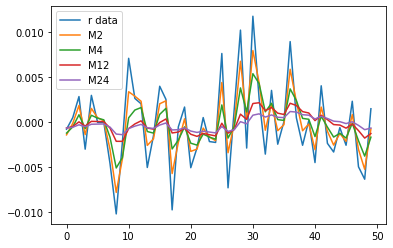

In [47]:
t_final = 50

plt.plot(r[:t_final], label='r data')
plt.plot(ema['M2'][:t_final], label='M2')
plt.plot(ema['M4'][:t_final], label='M4')
plt.plot(ema['M12'][:t_final], label='M12')
plt.plot(ema['M24'][:t_final], label='M24')
plt.legend()
